<a href="https://colab.research.google.com/github/subminu/Neural-Network-from-scratch/blob/main/Neural_Network_from_scratch_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3-layer Neural Network for Classification 
without the deep learning framework (only python)

## 0.  Import dependency package

In [ ]:
import numpy as np
import gzip
from matplotlib import pyplot as plt

from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

## 1. Load data

In [ ]:
def extract_images(file):
    with gzip.open(file, 'r') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        n_images = int.from_bytes(f.read(4), 'big')
        n_rows = int.from_bytes(f.read(4), 'big')
        n_cols = int.from_bytes(f.read(4), 'big')
  
        images = np.frombuffer(f.read(), dtype=np.uint8)\
            .reshape((n_images, n_rows, n_cols))
        return images


def extract_labels(file):
    with gzip.open(file, 'r') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        n_targets = int.from_bytes(f.read(4), 'big')

        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

In [ ]:
X_t = extract_images("/content/train-images-idx3-ubyte.gz")
Y_t = extract_labels("/content/train-labels-idx1-ubyte.gz")
X_r = extract_images("/content/t10k-images-idx3-ubyte.gz")
Y_r = extract_labels("/content/t10k-labels-idx1-ubyte.gz")

X_t = X_t.reshape(-1,784)
X_r = X_r.reshape(-1,784)

# normalization
X_t = X_t / 255
X_r = X_r / 255

## 2. Generate Neural Network

### 2.0 Activation Function

In [ ]:
class ReLU:
    def prop(self, X):
        return np.maximum(0, X)
    
    def derivative(self, X):
        result = np.copy(X)
        result[result >= 0] = 1
        result[result < 0] = 0
        return result

class LeakyReLU:
    def __init__(self, hyper=0.01):
        self.hyper = hyper
        
    def prop(self, X):
        return np.maximum(self.hyper*X, X)
    
    def derivative(self, X):
        result = np.copy(X)
        result[result >= 0] = 1
        result[result < 0] = self.hyper
        return result

### 2.1 Layer_Dense

In [ ]:
class Layer_dense:
    def __init__(self, input_size, output_size, activation, output_layer=False):
        # parameters
        self.W = np.random.normal(size=(input_size, output_size))
        self.b = np.random.normal(size=(1,output_size))

        # parameters(derivative)
        self.dW = None
        self.db = None

        # history
        self.inputs = None
        self.L = None

        # activation
        self.activation_func = activation()

        # flag
        self.output_layer = output_layer
    
    def prop(self, X):
        self.inputs = X
        self.L = np.dot(X, self.W) + self.b
        self.outputs = self.activation_func.prop(self.L) 
        return self.outputs
    
    def backprop(self, dZ):
        if self.output_layer:
            dZ = self.activation_func.derivative(dZ)
        else:
            dZ = np.multiply(self.activation_func.derivative(self.L), dZ)
        
        self.dW = np.dot(self.inputs.T, dZ)
        self.db = np.sum(dZ, axis=0, keepdims = True)

        return np.dot(dZ, self.W.T)
    
    def update(self, learning_rate):
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db

### 2.2 Softmax

In [ ]:
class Softmax:
    def __init__(self):
        self.inputs = None
    
    def prop(self, X):
        self.inputs = X
        X -= np.max(X, axis=1, keepdims=True)
        return np.exp(X)/np.sum(np.exp(X), axis=1, keepdims=True)
    
    def derivative(self, Y):
        """This function was used for derivative loss_func(softmax(Y_hat),Y)"""
        result = self.prop(self.inputs)
        result[np.arange(result.shape[0]),Y] -= 1
        return result 
    
    def _derivative(self, X):
        """This function was not used, just implementation of partial derivative"""
        result = np.zeros((*X.shape,X.shape[-1]))
        S = self.prop(X)
        for k, V in enumerate(X):
            for i,x1 in enumerate(*V):
                for j,x2 in enumerate(*V):
                    if i==j:
                        result[k,i,j] = S[k,i] * (1 - S[k,j])
                    else:
                        result[k,i,j] = S[k,i] * S[k,j] * -1
        return result

### 2.3 Multi-Class Cross entropy function

In [ ]:
class Cross_entropy:
    def prop(self, Y_hat, Y):
        return np.sum(-1 * np.log(Y_hat[np.arange(Y_hat.shape[0]),Y] + 1e-7))
    

    def derivative(self, Y_hat, Y):
        """This function was not used, just implementation of derivative"""
        result = np.zeros(Y_hat.shape)
        result[range(Y_hat.shape[0]),Y] = -1 * (1/Y_hat[np.arange(Y_hat.shape[0]),Y])
        return result

### 2.4 Neural Network

In [ ]:
class NN:
    def __init__(self, X_t, Y_t, loss, learning_rate, batch_size, epoch):
        np.random.seed(0)
        self.X_t, self.Y_t, self.X_v, self.Y_v = self.split_data_to_vaild_and_training(X_t,Y_t)
        
        self.loss_func = loss()
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epoch = epoch
        
        self.layers = []
        self.inputs = []

        self.history_t = []
        self.history_v = []


    def split_data_to_vaild_and_training(self,X,Y):
        num = X.shape[0]
        s = np.arange(num)
        np.random.shuffle(s)
        return X[s][:int(num*0.9)]\
        , Y[s][:int(num*0.9)]\
        , X[s][int(num*0.9):num+1]\
        , Y[s][int(num*0.9):num+1]

    def add(self, layer):
        self.layers.append(layer)
    
    def prop(self, X):
        result = X
        self.inputs = [X]

        for i, layer in enumerate(self.layers):
            result = layer.prop(result)
            self.inputs.append(result)

        return result
    
    def backprop(self, dZ):
        for layer in reversed(self.layers):
            dZ = layer.backprop(dZ)
            layer.update(self.learning_rate)
    
    def fit(self, verbose=True):
        for i in range(self.epoch):
            for X,Y in self.batch_iter():
                self.prop(X)
                self.backprop(Y)
            loss = self.get_loss(self.X_t,self.Y_t)
            acc = self.get_acc(self.X_t, self.Y_t)
            val_loss = self.get_loss(self.X_v, self.Y_v)
            val_acc = self.get_acc(self.X_v, self.Y_v)
            if verbose:
                print(f"[{i+1}/{self.epoch}] loss: {loss:.4f} acc: {acc:.4f} val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}")
            self.history_t.append(loss)
            self.history_v.append(val_loss)
    
    def batch_iter(self):
        div = int(self.X_t.shape[0] / self.batch_size)
        mod = self.X_t.shape[0] % self.batch_size
        n = div
        
        for i in range(n):
            if i == n - 1:
                yield self.X_t[i*self.batch_size:(i+1)*self.batch_size+mod+1],\
                 self.Y_t[i*self.batch_size:(i+1)*self.batch_size+mod+1]
            else:
                yield self.X_t[i*self.batch_size:(i+1)*self.batch_size],\
                 self.Y_t[i*self.batch_size:(i+1)*self.batch_size]
    
    def predict(self, X):
        return np.argmax(self.prop(X), axis=1)

    def get_loss(self, X, Y):
        return self.loss_func.prop(self.prop(X),Y) / X.shape[0]

    def get_acc(self, X, Y):
        return np.sum([1 for correct in np.equal(self.predict(X),Y) if correct]) / X.shape[0] * 100

    def show_loss_graph(self):
        plt.plot(range(self.epoch), self.history_t, label="train")
        plt.plot(range(self.epoch), self.history_v, label="vaildation")
        plt.title("epoch-loss graph")
        plt.legend(["train", "validation"])
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.show()
    
    def show_top_3_with_probability(self, X):
        Y_hat = self.predict(X)
        Y_softmax = np.max(self.inputs[-1], axis=1)
        Y_packed = sorted(list(zip(Y_hat, Y_softmax, X)), key=lambda x: x[1], reverse=True)
        datas = [[] for _ in range(10)]
        for obj in Y_packed:
            if len(datas[obj[0]]) < 3:
                datas[obj[0]].append((obj[1], obj[2].reshape(28,28)))
            if np.all(np.equal(3, [len(c) for c in datas])):
                break
        
        f = plt.figure(figsize=(8,8))
        for i, class_data in enumerate(datas):
            for j, data in enumerate(class_data,1):
                subplot = f.add_subplot(10, 3, (i*3)+j)
                subplot.imshow(data[1], cmap=plt.cm.gray_r)
                subplot.set_title(round(data[0],2))
                subplot.set_axis_off()
        plt.tight_layout()
        
    def show_confusion_matrix(self, X_test, Y_test):
        Y_hat = self.predict(X_test)
        cm = np.zeros((10,10))

        for y1,y2 in zip(Y_hat,Y_test):
          cm[y1,y2] += 1

        cm /= np.sum(cm, axis=1, keepdims=True)

        matfig = plt.figure(figsize=(10,10))
        plt.matshow(cm, cmap=plt.get_cmap('Blues'),fignum=matfig.number)
        plt.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
        plt.title("confusion_matrix")
        plt.xlabel("Y_label")
        plt.ylabel("Y_pred")
        plt.xticks(np.arange(10))
        plt.yticks(np.arange(10))
        plt.colorbar(shrink=0.8)
        for (x, y), value in np.ndenumerate(cm):
            plt.text(x, y, f"{value:.2f}", va="center", ha="center")
        plt.plot()

In [ ]:
def backprop(self, Y):
        output_layer = True
        for i,layer in enumerate(reversed(self.layers),2):
            if output_layer:
                dZ = layer.activation_derivative(self.inputs[-1], Y)
                output_layer = False
            else:
                dZ = np.multiply(layer.activation_derivative(), dZ)
            dW = np.dot(self.inputs[-i].T, dZ)
            db = np.sum(dZ, axis=0, keepdims = True)
            dZ = np.dot(dZ, layer.derivative().T)
            layer.update(self.learning_rate, dW, db)

## 3. NN with ReLU

In [ ]:
# X_t, Y_t, loss, learning_rate, batch_size, epoch
nn = NN(X_t, Y_t, Cross_entropy, 1e-3, 64, 100)
nn.add(Layer_dense(784,32,ReLU))
nn.add(Layer_dense(32,10,ReLU))
nn.add(Layer_dense(10,10,Softmax,True))

In [ ]:
nn.fit()

[1/100] loss: 2.3039 acc: 11.2852 val_loss: 2.3050 val_acc: 11.5500
[2/100] loss: 2.3018 acc: 11.2944 val_loss: 2.3028 val_acc: 11.5667
[3/100] loss: 2.3009 acc: 11.3093 val_loss: 2.3021 val_acc: 11.5833
[4/100] loss: 2.2999 acc: 11.3333 val_loss: 2.3014 val_acc: 11.6333
[5/100] loss: 2.2981 acc: 11.4537 val_loss: 2.3013 val_acc: 11.7000
[6/100] loss: 2.2945 acc: 11.6704 val_loss: 2.3015 val_acc: 11.8333
[7/100] loss: 2.0360 acc: 21.2574 val_loss: 2.0279 val_acc: 21.6167
[8/100] loss: 1.9194 acc: 23.3426 val_loss: 1.8989 val_acc: 24.0167
[9/100] loss: 1.8597 acc: 26.2685 val_loss: 1.8349 val_acc: 27.0667
[10/100] loss: 1.7690 acc: 29.7852 val_loss: 1.7495 val_acc: 30.2333
[11/100] loss: 1.6933 acc: 32.2333 val_loss: 1.6704 val_acc: 32.7500
[12/100] loss: 1.6291 acc: 34.5611 val_loss: 1.6113 val_acc: 34.9167
[13/100] loss: 1.4928 acc: 40.1037 val_loss: 1.4688 val_acc: 40.6833
[14/100] loss: 1.3640 acc: 47.7926 val_loss: 1.3444 val_acc: 48.0833
[15/100] loss: 1.2827 acc: 51.3019 val_loss

In [ ]:
nn.get_acc(X_r,Y_r)

92.53

### 3.1 Loss Graph

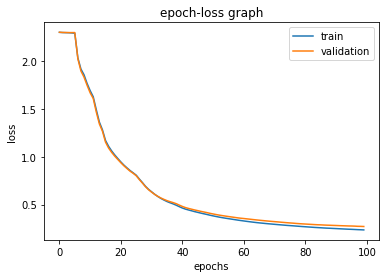

In [ ]:
nn.show_loss_graph()

### 3.2 Top 3 with probability

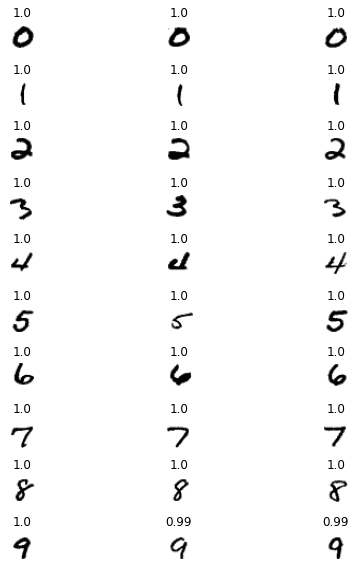

In [ ]:
nn.show_top_3_with_probability(X_r)

### 3.3 Confusion matrix

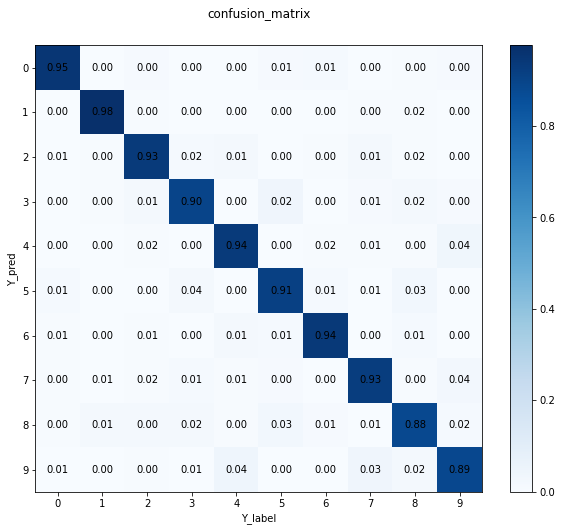

In [ ]:
nn.show_confusion_matrix(X_r, Y_r)

## 4. NN with LeakyReLU

In [ ]:
# X_t, Y_t, loss, learning_rate, batch_size, epoch
nn1 = NN(X_t, Y_t, Cross_entropy, 1e-3, 64, 100)
nn1.add(Layer_dense(784,32,LeakyReLU))
nn1.add(Layer_dense(32,10,LeakyReLU))
nn1.add(Layer_dense(10,10,Softmax, True))

In [ ]:
nn1.fit()

[1/100] loss: 1.6730 acc: 44.0222 val_loss: 1.6530 val_acc: 44.8000
[2/100] loss: 1.2483 acc: 56.4630 val_loss: 1.2174 val_acc: 56.6833
[3/100] loss: 1.0102 acc: 65.1074 val_loss: 0.9853 val_acc: 65.5833
[4/100] loss: 0.8493 acc: 72.4130 val_loss: 0.8263 val_acc: 72.8500
[5/100] loss: 0.7152 acc: 77.7759 val_loss: 0.6918 val_acc: 78.1500
[6/100] loss: 0.6307 acc: 80.8278 val_loss: 0.6082 val_acc: 81.3000
[7/100] loss: 0.5914 acc: 82.0574 val_loss: 0.5715 val_acc: 82.6667
[8/100] loss: 0.5514 acc: 83.3204 val_loss: 0.5329 val_acc: 84.0000
[9/100] loss: 0.5238 acc: 84.1815 val_loss: 0.5073 val_acc: 84.7000
[10/100] loss: 0.4963 acc: 85.0093 val_loss: 0.4824 val_acc: 85.7333
[11/100] loss: 0.4791 acc: 85.4944 val_loss: 0.4666 val_acc: 86.3500
[12/100] loss: 0.4671 acc: 85.8074 val_loss: 0.4569 val_acc: 86.9000
[13/100] loss: 0.4538 acc: 86.2981 val_loss: 0.4443 val_acc: 87.2333
[14/100] loss: 0.4432 acc: 86.6537 val_loss: 0.4355 val_acc: 87.4500
[15/100] loss: 0.4349 acc: 86.8519 val_loss

In [ ]:
nn1.get_acc(X_r,Y_r)

### 4.1 Loss graph

In [ ]:
nn1.show_loss_graph()

### 4.2 Top 3 with probability

In [ ]:
nn1.show_top_3_with_probability(X_r)

### 4.3 Confusion matrix

In [ ]:
nn1.show_confusion_matrix(X_r,Y_r)

## 5. Discussion

### 5.1 Experiment environment

Both Neural Network(a.k.a NN) using ReLU and another one using LeakyReLU were trained on exactly same environment except hyperparameter of LeakyReLU.

#### 5.1.1 Parameters

| Parameters                                      | Values  |
| ----------------------------------------------- | ------- |
| learning rate                                   | 1e-3    |
| batch size                                      | 64      |
| epochs                                          | 100     |
| ratio between a training set and validation set | 0.9/0.1 |
| hyperparameter of LeakyReLU                     | 0.01    |

#### 5.1.2 NN model structure

| Name (input, output) |
| :------------------: |
|   Input (-1, 784)    |
|  Layer_1 (784, 32)   |
|   Layer_2 (32, 10)   |
|   Softmax (10, 10)   |


### 5.2 Comparison

|             | ReLU  | LeakyReLU |
| ----------- | :---- | :-------- |
| Accuracy(%) | 92.53 | 93.7      |

The above table shows that the NN using LeakyReLU has more higher accuracy.

In the case of LeakyReLU at the beginning of learning, since it has a slope even for negative inputs, so learning started quickly. On the other hand, in the model using ReLU, it can be seen through loss_graph that learning started relatively slowly at the beginning.